In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt

import jaxley as jx
from jaxley.channels.channel import Channel
from jaxley.solver_gate import solve_inf_gate_exponential, save_exp

from jaxley_mech.synapses.dms98 import AMPA, GABAa, GABAb, NMDA, META
from jaxley_mech.channels.hh import Leak, Na, K

In [2]:
META

{'reference': 'Destexhe, A., Mainen, Z. F., & Sejnowski, T. J. (1998). Kinetic models of synaptic transmission. Methods in neuronal modeling, 2, 1-25.',
 'link': 'https://www.csc.kth.se/utbildning/kth/kurser/DD2435/biomod12/kursbunt/f9/KochCh1Destexhe.pdf',
 'source': 'https://modeldb.science/18500?tab=2'}

## Setting up

In [3]:
# To match the result from the NEURON demos, the rate constants are modified
# according to Traub & Miles, Neuronal Networks of the Hippocampus, Cambridge, 1991

def m_gate(v):
    v -= -63 + 1e-6
    alpha_m = 0.32 * (13 - v) / (save_exp(13-v)/4 - 1)
    beta_m = 0.28 * (v - 40) / (save_exp((v-40)/5) - 1)
    return alpha_m, beta_m

def h_gate(v):
    v -= -63 + 1e-6
    alpha_h = 0.128 * save_exp((17 - v)/18)
    beta_h = 4 / (save_exp((40-v)/5) + 1)
    return alpha_h, beta_h


def n_gate(v):
    v -= -63 + 1e-6
    alpha_n = 0.032 * (15 - v) / (save_exp(15-v)/5 - 1)
    beta_n = 0.5 * save_exp((10-v)/40)
    return alpha_n, beta_n

na = Na()
k = K()
na.m_gate = m_gate
na.h_gate = h_gate
k.n_gate = n_gate

## AMPA

In [4]:
comp = jx.Compartment()
comp.set("length", 10)
comp.set("radius", 5)
comp.set("v", -70)

comp.insert(Leak())
comp.set("Leak_gLeak", 1/5000)
comp.set("Leak_eLeak", -70)

comp.insert(na)
comp.set("Na_gNa", 0.1)
comp.set("Na_eNa", 50)

comp.insert(k)
comp.set("K_gK", 0.03)
comp.set("K_eK", -90)

branch = jx.Branch(comp, 1)
cell = jx.Cell(branch, parents=[-1])
net = jx.Network([cell for _ in range(2)])

pre = net.cell(0).branch(0).comp(0)
post = net.cell(1).branch(0).comp(0)

jx.connect(pre, post, AMPA(name="AMPA"))

In [5]:
# Stimulus.
i_delay = 1.  # ms
i_amp = 0.1  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 40.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

# stimulate the pre-synaptic compartment
currents = [
    jx.step_current(i_delay, i_dur, i_amp, dt, t_max),
    jx.step_current(i_delay, i_dur * 5, i_amp, dt, t_max)
]
res = []
from copy import deepcopy
for current in currents:
    net0 = deepcopy(net)
    net0.cell(0).branch(0).loc(0.5).stimulate(current, verbose=False)

    # record the membrane potential of the pre- and post-synaptic compartments
    net0.cell(0).branch(0).loc(0.5).record(verbose=False)
    net0.cell(1).branch(0).loc(0.5).record(verbose=False)

    net0.cell(1).branch(0).loc(0.5).record("AMPA_R", verbose=False)
    net0.cell(1).branch(0).loc(0.5).record("AMPA_C", verbose=False)

    s = jx.integrate(net0, delta_t=dt)
    res.append(s)


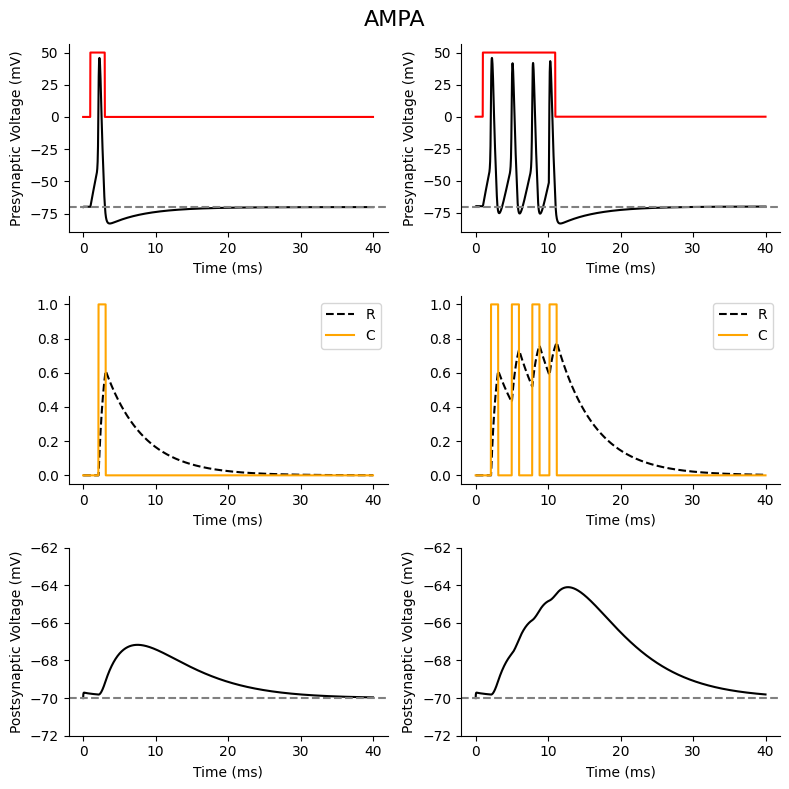

In [6]:
fig, ax = plt.subplot_mosaic([['PRE0', 'PRE1'], ['U0', "U1"], ['POST0', "POST1"]], figsize=(8,8))

for i in range(2):
    ax[f"PRE{i}"].plot(time_vec, currents[i] * 500, color="red", label='Injected Current (nA)')
    ax[f"PRE{i}"].plot(time_vec, res[i][0].T[:-1], color="black")
    ax[f"PRE{i}"].set_xlabel("Time (ms)")
    ax[f"PRE{i}"].set_ylabel("Presynaptic Voltage (mV)")
    ax[f"PRE{i}"].axhline(-70, color="gray", linestyle="--")
    # ax[f"PRE{i}"].set_ylim(-80, 40)


    ax[f"U{i}"].plot(time_vec, res[i][2].T[:-1], label="R", color='black', linestyle="--")
    ax[f"U{i}"].plot(time_vec, res[i][3].T[:-1], label="C", color='orange')
    ax[f"U{i}"].set_xlabel("Time (ms)")
    ax[f"U{i}"].legend()

    ax[f"POST{i}"].plot(time_vec, res[i][1].T[:-1], color="black")
    ax[f"POST{i}"].set_xlabel("Time (ms)")
    ax[f"POST{i}"].set_ylabel("Postsynaptic Voltage (mV)")
    ax[f"POST{i}"].axhline(-70, color="gray", linestyle="--")
    ax[f"POST{i}"].set_ylim(-72, -62)

    for a in ax.values():
        a.spines[['top', 'right']].set_visible(False)

    fig.tight_layout()
    fig.suptitle("AMPA", fontsize=16)

## NMDA

In [7]:
comp = jx.Compartment()
comp.set("length", 10)
comp.set("radius", 5)
comp.set("v", -70)

comp.insert(Leak())
comp.set("Leak_gLeak", 1/5000)
comp.set("Leak_eLeak", -70)

comp.insert(na)
comp.set("Na_gNa", 0.1)
comp.set("Na_eNa", 50)

comp.insert(k)
comp.set("K_gK", 0.03)
comp.set("K_eK", -90)

branch = jx.Branch(comp, 1)
cell = jx.Cell(branch, parents=[-1])
net = jx.Network([cell for _ in range(2)])

pre = net.cell(0).branch(0).comp(0)
post = net.cell(1).branch(0).comp(0)

nmda = NMDA(name="NMDA")
nmda.synapse_params["NMDA_gNMDA"] = 0.25e-2
# only with 0.25e-2 μS, the postsynaptic voltage is close to the one reported in the paper
# the paper reported the estimated maximum conductance (gNMDA) is 0.01 ~ 0.6 nS (0.01e-3 ~ 0.6e-3 μS), 
# however, the demo code used 0.001 μS (1e-2 μS)
# but even with that, the resulted postsynaptic voltage is still only half of the one reported in the figure 1.4B
nmda.synapse_params["NMDA_eNMDA"] = 0
nmda.synapse_params["NMDA_Cmax"] = 1
nmda.synapse_params["NMDA_Cdur"] = 1
nmda.synapse_params["NMDA_alpha"] = 0.072
nmda.synapse_params["NMDA_beta"] = 0.0066
nmda.synapse_params["NMDA_Mg"] = 1

jx.connect(pre, post, nmda)

# Stimulus.
i_delay = 1.  # ms
i_amp = 0.1  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.1  # ms
t_max = 500.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

# stimulate the pre-synaptic compartment
currents = [
    jx.step_current(i_delay, i_dur, i_amp, dt, t_max), # one presynaptic spike
    jx.step_current(i_delay, i_dur * 5, i_amp, dt, t_max) # 10 presynaptic spikes
]

# stimulate the pre-synaptic compartment
res = []
from copy import deepcopy
for current in currents:
    net0 = deepcopy(net)
    net0.cell(0).branch(0).loc(0.5).stimulate(current, verbose=False)

    # record the membrane potential of the pre- and post-synaptic compartments
    net0.cell(0).branch(0).loc(0.5).record(verbose=False)
    net0.cell(1).branch(0).loc(0.5).record(verbose=False)

    net0.cell(1).branch(0).loc(0.5).record("NMDA_R", verbose=False)
    net0.cell(1).branch(0).loc(0.5).record("NMDA_C", verbose=False)

    s = jx.integrate(net0, delta_t=dt)
    res.append(s)


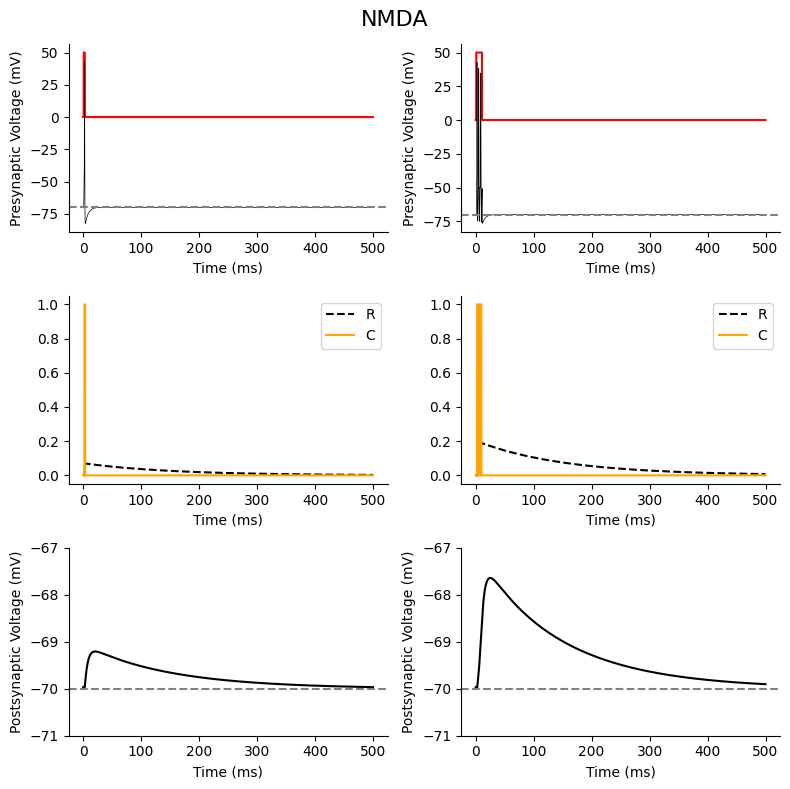

In [8]:
fig, ax = plt.subplot_mosaic([['PRE0', 'PRE1'], ['U0', "U1"], ['POST0', "POST1"]], figsize=(8,8))

for i in range(2):
    ax[f"PRE{i}"].plot(time_vec, currents[i] * 500, color="red", label='Injected Current (nA)')
    ax[f"PRE{i}"].plot(time_vec, res[i][0].T[:-1], color="black", linewidth=0.5)
    ax[f"PRE{i}"].set_xlabel("Time (ms)")
    ax[f"PRE{i}"].set_ylabel("Presynaptic Voltage (mV)")
    ax[f"PRE{i}"].axhline(-70, color="gray", linestyle="--")

    ax[f"U{i}"].plot(time_vec, res[i][2].T[:-1], label="R", color='black', linestyle="--")
    ax[f"U{i}"].plot(time_vec, res[i][3].T[:-1], label="C", color='orange')
    ax[f"U{i}"].set_xlabel("Time (ms)")
    ax[f"U{i}"].legend()

    ax[f"POST{i}"].plot(time_vec, res[i][1].T[:-1], color="black")
    ax[f"POST{i}"].set_xlabel("Time (ms)")
    ax[f"POST{i}"].set_ylabel("Postsynaptic Voltage (mV)")
    ax[f"POST{i}"].axhline(-70, color="gray", linestyle="--")
    ax[f"POST{i}"].set_ylim(-71, -67)

    for a in ax.values():
        a.spines[['top', 'right']].set_visible(False)

    fig.tight_layout()
    fig.suptitle("NMDA", fontsize=16)

## GABAa

In [9]:
comp = jx.Compartment()
comp.set("length", 10)
comp.set("radius", 5)
comp.set("v", -70)

comp.insert(Leak())
comp.set("Leak_gLeak", 1/5000)
comp.set("Leak_eLeak", -70)
comp.insert(na)
comp.set("Na_gNa", 0.1)
comp.set("Na_eNa", 50)

comp.insert(k)
comp.set("K_gK", 0.03)
comp.set("K_eK", -90)

branch = jx.Branch(comp, 1)
cell = jx.Cell(branch, parents=[-1])
net = jx.Network([cell for _ in range(2)])

pre = net.cell(0).branch(0).comp(0)
post = net.cell(1).branch(0).comp(0)

jx.connect(pre, post, GABAa(name="GABAa"))

# Stimulus.
i_delay = 1.  # ms
i_amp = 0.1  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 40.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

# stimulate the pre-synaptic compartment
currents = [
    jx.step_current(i_delay, i_dur, i_amp, dt, t_max),
    jx.step_current(i_delay, i_dur * 5, i_amp, dt, t_max)
]

# stimulate the pre-synaptic compartment
res = []
from copy import deepcopy
for current in currents:
    net0 = deepcopy(net)
    net0.cell(0).branch(0).loc(0.5).stimulate(current, verbose=False)

    # record the membrane potential of the pre- and post-synaptic compartments
    net0.cell(0).branch(0).loc(0.5).record(verbose=False)
    net0.cell(1).branch(0).loc(0.5).record(verbose=False)

    net0.cell(1).branch(0).loc(0.5).record("GABAa_R", verbose=False)
    net0.cell(1).branch(0).loc(0.5).record("GABAa_C", verbose=False)

    s = jx.integrate(net0, delta_t=dt)
    res.append(s)


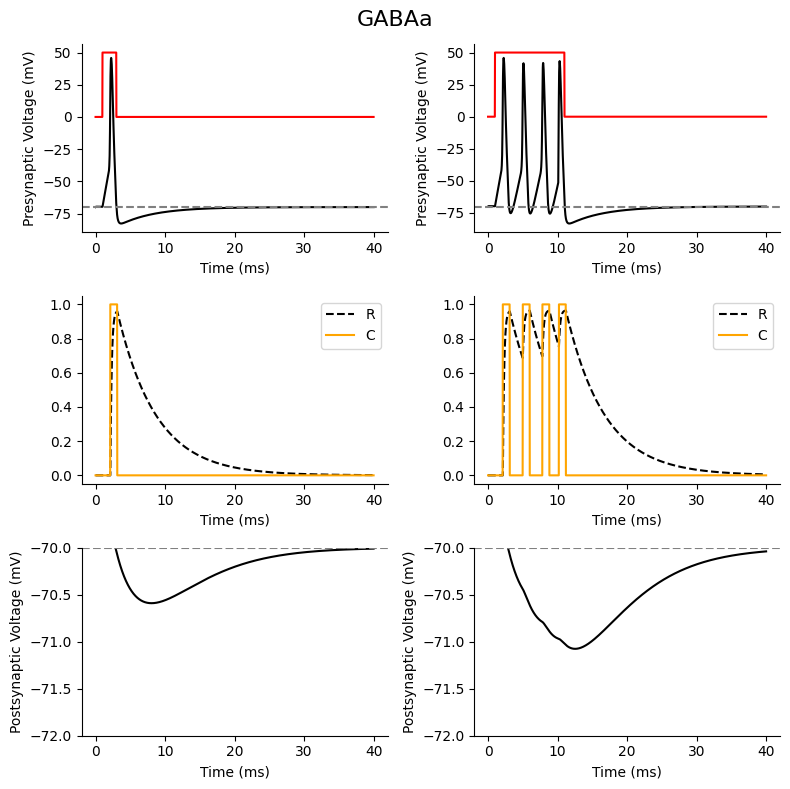

In [10]:
fig, ax = plt.subplot_mosaic([['PRE0', 'PRE1'], ['U0', "U1"], ['POST0', "POST1"]], figsize=(8,8))

for i in range(2):
    ax[f"PRE{i}"].plot(time_vec, currents[i] * 500, color="red", label='Injected Current (nA)')
    ax[f"PRE{i}"].plot(time_vec, res[i][0].T[:-1], color="black")
    ax[f"PRE{i}"].set_xlabel("Time (ms)")
    ax[f"PRE{i}"].set_ylabel("Presynaptic Voltage (mV)")
    ax[f"PRE{i}"].axhline(-70, color="gray", linestyle="--")

    ax[f"U{i}"].plot(time_vec, res[i][2].T[:-1], label="R", color='black', linestyle="--")
    ax[f"U{i}"].plot(time_vec, res[i][3].T[:-1], label="C", color='orange')
    ax[f"U{i}"].set_xlabel("Time (ms)")
    ax[f"U{i}"].legend()

    ax[f"POST{i}"].plot(time_vec, res[i][1].T[:-1], color="black")
    ax[f"POST{i}"].set_xlabel("Time (ms)")
    ax[f"POST{i}"].set_ylabel("Postsynaptic Voltage (mV)")
    ax[f"POST{i}"].axhline(-70, color="gray", linestyle="--")
    ax[f"POST{i}"].set_ylim(-72, -70)

    for a in ax.values():
        a.spines[['top', 'right']].set_visible(False)

    fig.tight_layout()
    fig.suptitle("GABAa", fontsize=16)

## GABAb

In [11]:
comp = jx.Compartment()
comp.set("length", 10)
comp.set("radius", 5)
comp.set("v", -70)

comp.insert(Leak())
comp.set("Leak_gLeak", 1/5000)
comp.set("Leak_eLeak", -70)
comp.insert(na)
comp.set("Na_gNa", 0.1)
comp.set("Na_eNa", 50)

comp.insert(k)
comp.set("K_gK", 0.03)
comp.set("K_eK", -90)

branch = jx.Branch(comp, 1)
cell = jx.Cell(branch, parents=[-1])
net = jx.Network([cell for _ in range(2)])

pre = net.cell(0).branch(0).comp(0)
post = net.cell(1).branch(0).comp(0)

gabab = GABAb(name="GABAb")
gabab.synapse_params["GABAb_gGABAb"] = 0.0001
gabab.synapse_params["GABAb_eGABAb"] = -95
gabab.synapse_params["GABAb_Cmax"] = 1.
gabab.synapse_params["GABAb_Cdur"] = 1. # changed from 84

# parameters in the demo, but in the MOD file there're no alpha and beta
# and setting Cdur to 84 will cause the simulation to fail
# gabab.synapse_params["GABAb_Cdur"] = 1
# gabab.synapse_params["GABAb_alpha"] = 0.016
# gabab.synapse_params["GABAb_beta"] = 0.0047
jx.connect(pre, post, gabab)


# Stimulus.
i_delay = 1.  # ms
i_amp = 0.1  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.1  # ms
t_max = 1000.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

# stimulate the pre-synaptic compartment
currents = [
    jx.step_current(i_delay, i_dur, i_amp, dt, t_max),
    jx.step_current(i_delay, i_dur * 15, i_amp, dt, t_max)
]

# stimulate the pre-synaptic compartment
res = []
from copy import deepcopy
for current in currents:
    net0 = deepcopy(net)
    net0.cell(0).branch(0).loc(0.5).stimulate(current, verbose=False)

    # record the membrane potential of the pre- and post-synaptic compartments
    net0.cell(0).branch(0).loc(0.5).record(verbose=False)
    net0.cell(1).branch(0).loc(0.5).record(verbose=False)

    net0.cell(1).branch(0).loc(0.5).record("GABAb_R", verbose=False)
    net0.cell(1).branch(0).loc(0.5).record("GABAb_C", verbose=False)

    s = jx.integrate(net0, delta_t=dt)
    res.append(s)


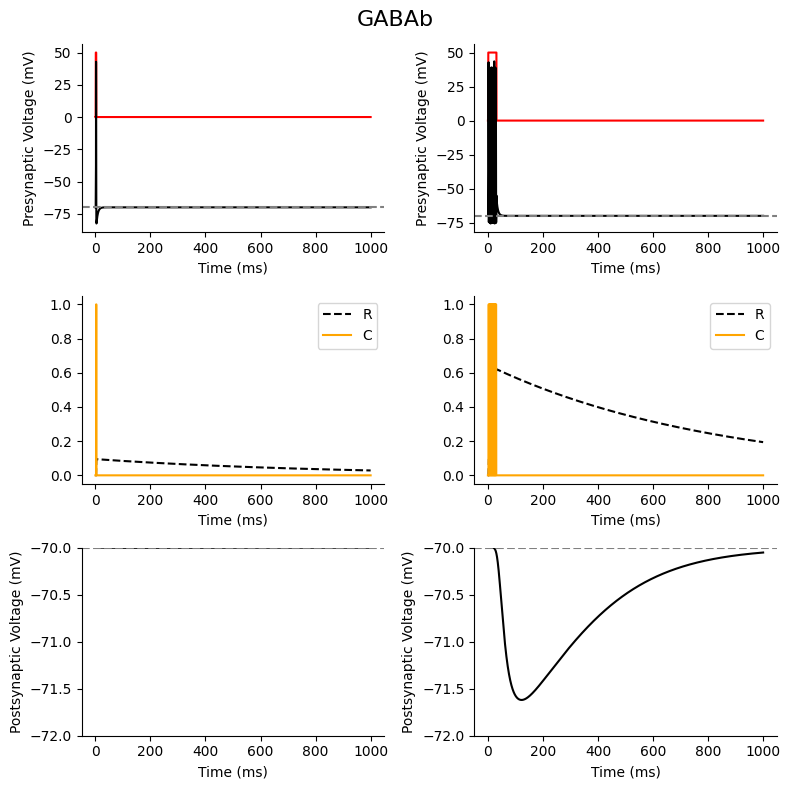

In [12]:
fig, ax = plt.subplot_mosaic([['PRE0', 'PRE1'], ['U0', "U1"], ['POST0', "POST1"]], figsize=(8,8))

for i in range(2):
    ax[f"PRE{i}"].plot(time_vec, currents[i] * 500, color="red", label='Injected Current (nA)')
    ax[f"PRE{i}"].plot(time_vec, res[i][0].T[:-1], color="black")
    ax[f"PRE{i}"].set_xlabel("Time (ms)")
    ax[f"PRE{i}"].set_ylabel("Presynaptic Voltage (mV)")
    ax[f"PRE{i}"].axhline(-70, color="gray", linestyle="--")

    ax[f"U{i}"].plot(time_vec, res[i][2].T[:-1], label="R", color='black', linestyle="--")
    ax[f"U{i}"].plot(time_vec, res[i][3].T[:-1], label="C", color='orange')
    ax[f"U{i}"].set_xlabel("Time (ms)")
    ax[f"U{i}"].legend()

    ax[f"POST{i}"].plot(time_vec, res[i][1].T[:-1], color="black")
    ax[f"POST{i}"].set_xlabel("Time (ms)")
    ax[f"POST{i}"].set_ylabel("Postsynaptic Voltage (mV)")
    ax[f"POST{i}"].axhline(-70, color="gray", linestyle="--")
    ax[f"POST{i}"].set_ylim(-72, -70)

    for a in ax.values():
        a.spines[['top', 'right']].set_visible(False)

    fig.tight_layout()
    fig.suptitle("GABAb", fontsize=16)

In [13]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-09-13 13:48:48CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.1.0

matplotlib: 3.8.3
jax       : 0.4.30
jaxley    : 0.1.2

Watermark: 2.4.3

